In [1]:
import sys
from pathlib import Path
project_root = Path().cwd().resolve().parent
sys.path.insert(0, str(project_root))

In [2]:
import sqlite3

import os, argparse, path_config, shutil
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from loguru import logger

import torch
from torch_geometric.utils import to_networkx, k_hop_subgraph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

from graph._multimodal_model_bilstm.GAT import GATClassifier as BiLSTMGAT, GATJKClassifier as BiLSTMV2GAT
from graph._multimodal_model_no_bilstm.GAT import GATClassifier as NoBiLSTMGAT, GATJKClassifier as NoBiLSTMV2GAT
from graph._unimodal_model.GAT import GATClassifier as UniGAT, GATJKClassifier as UniV2GAT
from graph._bimodal_model_bilstm.GAT import GATClassifier as BiGAT, GATJKClassifier as BiV2GAT

from graph.multimodal_bilstm.dataset import make_graph as BiLSTM_make_graph
from graph.multimodal_proxy.dataset import make_graph as Proxy_make_graph
from graph.multimodal_topic_bilstm.dataset import make_graph as TopicBiLSTM_make_graph
from graph.multimodal_topic_bilstm_proxy.dataset import make_graph as TopicProxyBiLSTM_make_graph
from graph.multimodal_topic_proxy.dataset import make_graph as TopicProxy_make_graph
from graph.unimodal_topic.dataset import make_graph as UniTopic_make_graph
from graph.bimodal_topic_bilstm_proxy.dataset import make_graph as BiTopicProxy_make_graph

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logger.remove()
logger.add(
  sys.stdout,
  colorize=True,
  format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
)

MODEL = {
  'multimodal_bilstm':BiLSTMGAT,
  'multimodal_proxy':NoBiLSTMGAT,
  'multimodal_topic_bilstm':BiLSTMGAT,
  'multimodal_topic_bilstm_proxy':BiLSTMGAT,
  'multimodal_topic_proxy':NoBiLSTMGAT,
  'unimodal_topic':UniGAT,
  'bimodal_topic_bilstm_proxy':BiGAT
}

V2_MODEL = {
  'multimodal_bilstm':BiLSTMV2GAT,
  'multimodal_proxy':NoBiLSTMV2GAT,
  'multimodal_topic_bilstm':BiLSTMV2GAT,
  'multimodal_topic_bilstm_proxy':BiLSTMV2GAT,
  'multimodal_topic_proxy':NoBiLSTMV2GAT,
  'unimodal_topic':UniV2GAT,
  'bimodal_topic_bilstm_proxy':BiV2GAT
}

MAKE_GRAPH = {
  'multimodal_bilstm':BiLSTM_make_graph,
  'multimodal_proxy':Proxy_make_graph,
  'multimodal_topic_bilstm':TopicBiLSTM_make_graph,
  'multimodal_topic_bilstm_proxy':TopicProxyBiLSTM_make_graph,
  'multimodal_topic_proxy':TopicProxy_make_graph,
  'unimodal_topic':UniTopic_make_graph,
  'bimodal_topic_bilstm_proxy':BiTopicProxy_make_graph
}

In [4]:
def fetch_from_db(db_path):
  con = sqlite3.connect(db_path)
  cursor = con.cursor()
  cursor.execute('''
    SELECT param_name, param_value 
    FROM trial_params
    WHERE trial_id = (
      SELECT trial_id
      FROM trial_values
      ORDER BY value DESC
      LIMIT 1
    );
  ''')
  best_hyperparams_list = cursor.fetchall()
  best_hyperparams_dict = {}

  for k, v in best_hyperparams_list:
    if k not in ['batch_size', 'focal_alpha', 'focal_gamma', 'lr', 'optimizer', 'weight_decay']:
      if k in ['use_text_proj', 'use_attention']:
        best_hyperparams_dict[k] = True if v==0.0 else False
      elif k in ['num_layers', 'bilstm_num_layers']:
        best_hyperparams_dict[k] = int(v)
      else:
        best_hyperparams_dict[k] = v

  cursor.execute('''
    SELECT value
    FROM trial_values
    ORDER BY value DESC
    LIMIT 1
  ''')
  best_f1 = cursor.fetchone()[0]
  
  return best_hyperparams_dict, best_f1

In [5]:
model_dir = 'checkpoints_optuna'
model_dir_ = 'multimodal_topic_bilstm_proxy_v2'
save_dir = 'graph_visualization'
save_dir_ = 'multimodal_topic_bilstm_proxy_v2_id_405_ipynb'
id = 405
mode = 'multimodal_topic_bilstm_proxy'
version = 2

best_model_path = os.path.join(path_config.ROOT_DIR, model_dir, model_dir_, 'best_model.pth')
db_path = os.path.join(path_config.ROOT_DIR, model_dir, model_dir_, 'logs', 'optuna_study.db')
assert os.path.exists(best_model_path) and os.path.exists(db_path), logger.error("Model path is wrong. Try again.")

In [6]:
logger.info(f"Processing data (Mode: {mode}, Id: {id})")

if "multimodal" in mode:
  logger.info(f"Doing with multimodal mode")
  graphs, dim_list, extras = MAKE_GRAPH[mode](
    ids = [id],
    labels = [1],                   # Temporary Label
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
    use_summary_node = True,
    t_t_connect = False,
    v_a_connect = False,
    explanation = True
  )

  t_dim = dim_list[0]
  v_dim = dim_list[1]
  a_dim = dim_list[2]

else:
  logger.info(f"Doing with non-multimodal mode")
  graphs, dim_list, extras = MAKE_GRAPH[mode](
    ids = [id],
    labels = 1,                   # Temporary Label
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
    use_summary_node = True,
    t_t_connect = False,
    explanation = True
  )

  t_dim = dim_list[0]
  if 'bimodal' in mode:
    v_dim = dim_list[1]

15:56:22 | INFO     | Processing data (Mode: multimodal_topic_bilstm_proxy, Id: 405)
15:56:22 | INFO     | Doing with multimodal mode
15:56:22 | INFO     | Getting your model
15:56:25 | INFO     | Model loaded
15:56:25 | INFO     | Switching CSV into Graphs


Dataframe -> Graph: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


In [7]:
topic_node_id, utterances, vision_input, audio_input = extras

best_hyperparams_dict, best_f1 = fetch_from_db(db_path)

logger.info(f"Best Params")
for k, v in best_hyperparams_dict.items():
  logger.info(f"  - {k}: {v}")
logger.info(f"=> F1-score: {best_f1}")

15:56:27 | INFO     | Best Params
15:56:27 | INFO     |   - a_dropout: 0.39294858998728843
15:56:27 | INFO     |   - bilstm_num_layers: 2
15:56:27 | INFO     |   - g_dropout: 0.24654580705928375
15:56:27 | INFO     |   - num_layers: 3
15:56:27 | INFO     |   - t_dropout: 0.25237807640094945
15:56:27 | INFO     |   - use_attention: True
15:56:27 | INFO     |   - use_text_proj: False
15:56:27 | INFO     |   - v_dropout: 0.3430548105111857
15:56:27 | INFO     | => F1-score: 0.7586206896551724


In [8]:
logger.info("==============================")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Loading your model (Device: {device})")

assert version in [1,2], logger.error("Version should be int type 1 or 2")

if version == 1:
  model_dict = MODEL
elif version == 2:
  model_dict = V2_MODEL

dropout_dict = {
  'text_dropout':best_hyperparams_dict.get('t_dropout', 0.0),
  'graph_dropout':best_hyperparams_dict.get('g_dropout', 0.0),
  'vision_dropout':best_hyperparams_dict.get('v_dropout', 0.0),
  'audio_dropout':best_hyperparams_dict.get('a_dropout', 0.0)
}

if "unimodal" in mode:
  model = model_dict[mode](
    text_dim=t_dim,
    hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
    num_layers=best_hyperparams_dict['num_layers'],
    num_classes=2,
    dropout_dict=dropout_dict,
    heads=8,
    use_summary_node=True,
    use_text_proj=best_hyperparams_dict['use_text_proj']
  ).to(device)
elif "bimodal" in mode:
  model = model_dict[mode](
    text_dim=t_dim,
    vision_dim=v_dim,
    hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
    num_layers=best_hyperparams_dict['num_layers'],
    bilstm_num_layers=best_hyperparams_dict['bilstm_num_layers'],
    num_classes=2,
    dropout_dict=dropout_dict,
    heads=8,
    use_attention=best_hyperparams_dict['use_attention'],
    use_summary_node=True,
    use_text_proj=best_hyperparams_dict['use_text_proj']
  ).to(device)
else:
  if 'bilstm' in mode:
    model = model_dict[mode](
      text_dim=t_dim,
      vision_dim=v_dim,
      audio_dim=a_dim,
      hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
      num_layers=best_hyperparams_dict['num_layers'],
      bilstm_num_layers=best_hyperparams_dict['bilstm_num_layers'],
      num_classes=2,
      dropout_dict=dropout_dict,
      heads=8,
      use_attention=best_hyperparams_dict['use_attention'],
      use_summary_node=True,
      use_text_proj=best_hyperparams_dict['use_text_proj']
    ).to(device)
  else:
    model = model_dict[mode](
      text_dim=t_dim,
      vision_dim=v_dim,
      audio_dim=a_dim,
      hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
      num_layers=best_hyperparams_dict['num_layers'],
      num_classes=2,
      dropout_dict=dropout_dict,
      heads=8,
      use_summary_node=True,
      use_text_proj=best_hyperparams_dict['use_text_proj']
    ).to(device)

best_model_state_dict = torch.load(best_model_path)
model.load_state_dict(best_model_state_dict)

15:56:27 | INFO     | ==============================
15:56:27 | INFO     | Loading your model (Device: cuda)


<All keys matched successfully>

In [9]:
sample_loader = DataLoader(graphs)

model.eval()
with torch.no_grad():
  for data in sample_loader:
    data = data.to(device)
    result, x, flat_node_types = model(data, explanation=True)
    x = x.cpu()
    y = torch.tensor([torch.sigmoid(result) > 0.5], dtype=torch.long)
y

tensor([1])

In [10]:
topic_node_id

{'개인 특성 및 경험': 0, '대인 관계 및 가족': 1, '생활 환경 및 취미': 2, '심리 상태 및 감정': 3}

In [11]:
topic_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'topic']
text_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'transcription']
proxy_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'proxy']
vision_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'vision']
audio_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'audio']

In [12]:
source_indices = graphs[0].edge_index[0].numpy()
target_indices = graphs[0].edge_index[1].numpy()

In [13]:
utterances, vision_input, audio_input = np.array(utterances), np.array(vision_input), np.array(audio_input)

In [14]:
# For the fist topic
topic_target_indices = np.where(target_indices==topic_indices[1])                         # extract index of target edge_index where target is the certain topic node
text_source_ids = source_indices[topic_target_indices]                                    # extract text node ids from source edge_index
text_valid_ids = text_source_ids[text_source_ids>len(topic_indices)]                      # delete topic node ids
topic_text_indices = np.where(np.isin(text_indices, text_valid_ids)==True)                # extract text(utterance) index from text indices
topic_utterances = utterances[topic_text_indices]

text_target_indices = np.where(np.isin(target_indices, text_valid_ids)==True)             # extract index of target edge_index where target is the text from first topic node
proxy_source_ids = source_indices[text_target_indices]                                    # extract proxy node ids from source edge_index

proxy_target_indices = np.where(np.isin(target_indices, proxy_source_ids)==True)          # extract index of target edge_index where target is the proxy from text
vision_audio_source_ids = source_indices[proxy_target_indices]                            # extract vision/audio node ids from source edge_index
topic_vision_indices = np.where(np.isin(vision_indices, vision_audio_source_ids)==True)   # extract vision index from vision indices
topic_audio_indices = np.where(np.isin(audio_indices, vision_audio_source_ids)==True)     # extract audio index from vision indices
topic_vision = vision_input[topic_vision_indices] 
topic_audio = vision_input[topic_audio_indices]

In [15]:
topic_node_dict = {v+1:str(k) for k,v in topic_node_id.items()}

c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48143 (\N{HANGUL SYLLAB

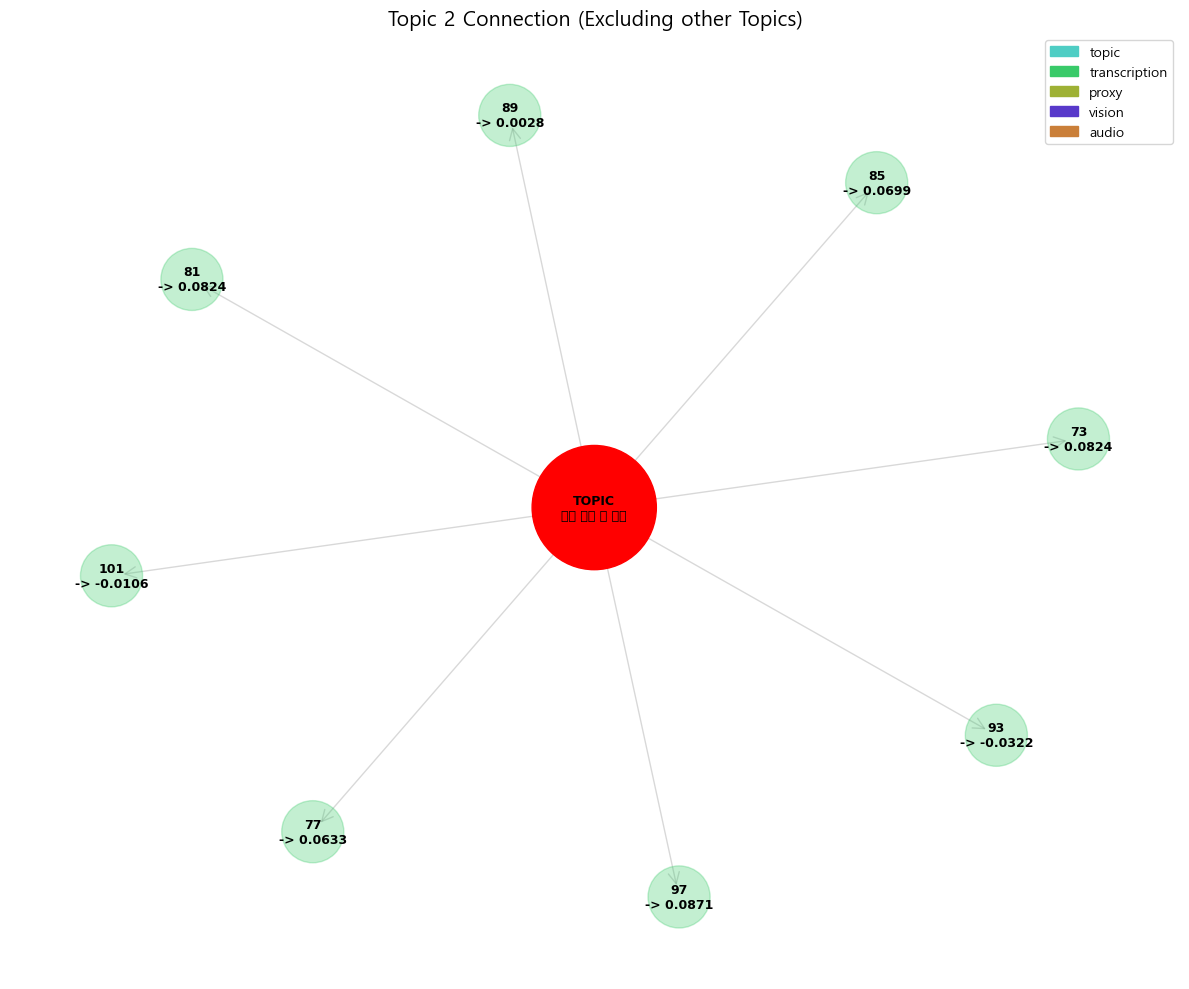

In [16]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

def visualize_topic_specific_graph(data, target_topic, all_topics, num_hops=1):
  exclude_topics = [t for t in all_topics if t != target_topic]
  edge_index = data.edge_index
  device = edge_index.device
  
  mask = ~torch.isin(edge_index[0], torch.tensor(exclude_topics).to(device)) & \
          ~torch.isin(edge_index[1], torch.tensor(exclude_topics).to(device))
  filtered_edge_index = edge_index[:, mask]

  subset, new_edge_index, mapping, edge_mask = k_hop_subgraph(
    target_topic, num_hops, filtered_edge_index, relabel_nodes=False
  )

  subset_x = data.x[subset]
  target_vec = data.x[target_topic].unsqueeze(0)
  
  # 코사인 유사도 계산
  similarities = F.cosine_similarity(target_vec, subset_x).cpu().detach().numpy()
  
  subset_node_types = np.array(data.node_types)[subset.cpu().numpy()]

  # 4. NetworkX 그래프 생성 및 속성 매핑
  G = nx.Graph()
  G.add_nodes_from(subset.tolist())
  G.add_edges_from(new_edge_index.t().tolist())

  node_labels = {}
  node_colors = []
  node_sizes = []
  node_values = [] # Alpha 값으로 활용
  
  color_map = {
    'topic': '#4ECDC4', 
    'transcription': "#39CA69",
    'proxy': "#9EB135",
    'vision': "#5839CA",
    'audio': "#CA7F39",
  }

  scale_factor = 7500

  for i, node_idx in enumerate(subset.tolist()):
    node_type = subset_node_types[i]
    sim_score = similarities[i]
    
    if node_idx == target_topic:
      node_labels[node_idx] = f"TOPIC\n{topic_node_dict.get(node_idx)}"
      node_colors.append('red') # 타겟 토픽은 강조
      node_sizes.append(8000)
      node_values.append(1.0)
    else:
      if node_type == 'transcription': 
        node_labels[node_idx] = f"{node_idx}\n-> {sim_score:.4f}"
      else:
        node_labels[node_idx] = f"{node_idx}"
      
      node_colors.append(color_map.get(node_type, 'skyblue'))
      node_sizes.append(max(2000, sim_score * scale_factor))
      node_values.append(max(0.3, sim_score))

  # 5. 시각화
  plt.figure(figsize=(12, 10))
  pos = nx.spring_layout(G, k=0.5, seed=42)
  
  # 노드 그리기
  nx.draw_networkx_nodes(G, pos,
                        node_color=node_colors,
                        node_size=node_sizes,
                        alpha=node_values)
  
  # 엣지 그리기
  nx.draw_networkx_edges(G, pos, edge_color='gray',
                        arrows=True, arrowstyle='->', arrowsize=20,
                        width=1.0, alpha=0.3)
  
  # 라벨 그리기
  nx.draw_networkx_labels(G, pos,
                        labels=node_labels,
                        font_size=9,
                        font_weight='bold')

  # 범례 설정
  legend_elements = [mpatches.Patch(color=c, label=t) for t, c in color_map.items()]
  plt.legend(handles=legend_elements, loc='upper right')
  
  plt.title(f"Topic {target_topic} Connection (Excluding other Topics)", fontsize=15)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

visualize_topic_specific_graph(graphs[0], 2, [1,2,3,4], num_hops=1)

In [17]:
text_valid_ids

array([ 73,  77,  81,  85,  89,  93,  97, 101], dtype=int64)

In [18]:
topic_utterances

array(["hmprobably with my. husband. and. i can't remember at the moment what it was about. ",
       'um well when you say my family do you meanmy  family from childhood or my current family. ',
       "okay well i guess my current family comes to mind i i have two daughtersand. my relationship's pretty good it's okay with them but they're teenagers which uh. you know. going they're going through a lot of hormones and. um. they can be kinda bitchy <laughter> and. ",
       "and um but i have hoped that you know they'll grow out of that and soon someday we'll have a really good relationshipum and then there's the husband which. i i guess i could say soon to be ex husband hopefully soon  <laughter>. we need to get a divorce but we're still together. due to financial reasons. and yeah. ",
       "yeah so that that's not good thethe relationship with the husband but um. but since we have determined that we need to divorce. our our we don't expect anything out out of each other so we don't

In [19]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.explain import Explainer, GNNExplainer
from captum.attr import IntegratedGradients, Saliency
from torch_geometric.data import Data, Batch

"""
=============================================================================
GATJKClassifier를 위한 개선된 Explanation 코드

주요 개선사항:
1. GATJKClassifier의 멀티모달 구조 완벽 지원
2. Vision/Audio LSTM 데이터 올바른 처리
3. GNNExplainer와 Captum 안정적 작동
4. 배치 처리 문제 해결

설명 방법:
1. SIMPLE: 입력 피처 기반 코사인 유사도 (가장 빠름)
2. COSINE: 모델 임베딩 기반 유사도 (모델 학습 반영)
3. GRADIENT: Captum gradient 기반 (피처 중요도)
4. GNN_EXPLAINER: 서브그래프 학습 기반 (구조 중요도)
=============================================================================
"""


# ============= 방법 1: SIMPLE (입력 피처 기반) =============
def explain_simple(model, data, target_topic):
    """
    입력 피처 기반 유사도
    - 가장 안정적이고 빠름
    - 모델 학습 결과 반영 안함
    """
    target_feature = data.x[target_topic].unsqueeze(0)
    node_attr = F.cosine_similarity(target_feature, data.x).cpu().numpy()
    
    edge_index = data.edge_index
    src_sim = node_attr[edge_index[0].cpu()]
    dst_sim = node_attr[edge_index[1].cpu()]
    edge_attr = (src_sim + dst_sim) / 2
    
    return node_attr, edge_attr, "Input Feature Similarity"


# ============= 방법 2: COSINE (모델 임베딩 기반) =============
def explain_with_model_embeddings(model, data, target_topic):
    """
    모델 학습 후 임베딩 기반 유사도
    - GATJKClassifier의 최종 노드 임베딩 사용
    - 모델이 학습한 관계성 반영
    """
    device = data.x.device
    model.eval()
    
    with torch.no_grad():
        # 단일 그래프를 배치로 변환
        if not hasattr(data, 'batch'):
            data.batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
        
        try:
            # 모델 forward로 node embeddings 추출
            x_text = data.x
            edge_index = data.edge_index
            
            # Text projection
            if hasattr(model, 'use_text_proj') and model.use_text_proj:
                x_text = model.text_proj(x_text)
            x_text = model.dropout_text(x_text)
            
            # Vision/Audio 처리
            node_types = np.array(data.node_types)
            vision_mask = node_types == 'vision'
            audio_mask = node_types == 'audio'
            
            x_vision_emb = torch.zeros(data.num_nodes, model.vision_dim, device=device)
            x_audio_emb = torch.zeros(data.num_nodes, model.audio_dim, device=device)
            
            # Vision LSTM
            if hasattr(data, 'x_vision') and data.x_vision.size(0) > 0:
                if hasattr(model, 'vision_lstm'):
                    packed_vision = torch.nn.utils.rnn.pack_padded_sequence(
                        data.x_vision, 
                        data.vision_lengths.cpu(), 
                        batch_first=True, 
                        enforce_sorted=False
                    )
                    _, (h_vision, _) = model.vision_lstm(packed_vision)
                    vision_out = h_vision[-1]
                    x_vision_emb[vision_mask] = model.vision_fc(vision_out)
            
            # Audio LSTM
            if hasattr(data, 'x_audio') and data.x_audio.size(0) > 0:
                if hasattr(model, 'audio_lstm'):
                    packed_audio = torch.nn.utils.rnn.pack_padded_sequence(
                        data.x_audio,
                        data.audio_lengths.cpu(),
                        batch_first=True,
                        enforce_sorted=False
                    )
                    _, (h_audio, _) = model.audio_lstm(packed_audio)
                    audio_out = h_audio[-1]
                    x_audio_emb[audio_mask] = model.audio_fc(audio_out)
            
            # 모든 피처 결합
            x = x_text + x_vision_emb + x_audio_emb
            
            # GAT layers with JK
            layer_outputs = []
            
            # Layer 1
            x = model.conv1(x, edge_index)
            x = model.norm1(x)
            x = F.elu(x)
            layer_outputs.append(x)
            
            # Layer 2
            if model.num_layers >= 3:
                x_in = x
                x = F.dropout(x, p=model.dropout_g, training=False)
                x = model.conv2(x, edge_index)
                x = model.norm2(x + x_in) if hasattr(model, 'norm2') else model.norm2(x)
                x = F.elu(x)
                layer_outputs.append(x)
            
            # Layer 3
            if model.num_layers >= 4:
                x_in = x
                x = F.dropout(x, p=model.dropout_g, training=False)
                x = model.conv3(x, edge_index)
                x = model.norm3(x + x_in) if hasattr(model, 'norm3') else model.norm3(x)
                x = F.elu(x)
                layer_outputs.append(x)
            
            # Layer 4
            x = F.dropout(x, p=model.dropout_g, training=False)
            x = model.conv4(x, edge_index)
            x = model.norm4(x)
            layer_outputs.append(x)
            
            # JK connection (concat all layers)
            if hasattr(model, 'jk_lin'):
                x = torch.cat(layer_outputs, dim=-1)
                x = model.jk_lin(x)
            
            # 임베딩 기반 유사도
            target_emb = x[target_topic].unsqueeze(0)
            node_attr = F.cosine_similarity(target_emb, x).cpu().numpy()
            
        except Exception as e:
            print(f"Model embedding extraction failed: {e}")
            print("Falling back to simple method...")
            return explain_simple(model, data, target_topic)
    
    edge_index = data.edge_index
    src_sim = node_attr[edge_index[0].cpu()]
    dst_sim = node_attr[edge_index[1].cpu()]
    edge_attr = (src_sim + dst_sim) / 2
    
    return node_attr, edge_attr, "Model Embedding Similarity"


# ============= 방법 3: GRADIENT (Captum) =============
class ModelWrapperForCaptum(torch.nn.Module):
    """Captum을 위한 모델 래퍼 - 텍스트 피처만 입력받음"""
    def __init__(self, model, base_data):
        super().__init__()
        self.model = model
        self.base_data = base_data
        
    def forward(self, x_text):
        """
        x_text: [num_nodes, text_dim] - 텍스트 피처만
        Vision/Audio는 base_data에서 가져옴
        """
        data = Data(
            x=x_text,
            edge_index=self.base_data.edge_index.clone(),
            y=self.base_data.y.clone() if hasattr(self.base_data, 'y') else None
        )
        
        # 커스텀 속성 복사
        if hasattr(self.base_data, 'x_vision'):
            data.x_vision = self.base_data.x_vision
        if hasattr(self.base_data, 'x_audio'):
            data.x_audio = self.base_data.x_audio
        if hasattr(self.base_data, 'vision_lengths'):
            data.vision_lengths = self.base_data.vision_lengths
        if hasattr(self.base_data, 'audio_lengths'):
            data.audio_lengths = self.base_data.audio_lengths
        if hasattr(self.base_data, 'node_types'):
            data.node_types = self.base_data.node_types
        
        # 배치 추가
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long, device=x_text.device)

        data.ptr = torch.tensor([0, data.num_nodes], dtype=torch.long, device=x_text.device)
        
        # 모델 forward
        output = self.model(data)
        
        return output


def explain_with_gradients(model, data, target_topic):
    """
    Captum Integrated Gradients 기반 설명
    - 텍스트 피처의 gradient 계산
    - Vision/Audio는 고정 (base_data에서)
    """
    device = data.x.device
    model.eval()
    
    try:
        # 래퍼 모델 생성
        wrapper = ModelWrapperForCaptum(model, data).to(device)
        
        # Integrated Gradients
        ig = IntegratedGradients(wrapper)
        
        # Baseline: 제로 벡터
        baseline_x = torch.zeros_like(data.x)
        
        # 피처가 requires_grad=True여야 함
        input_x = data.x.clone().requires_grad_(True)
        
        # Attribution 계산
        attributions = ig.attribute(
            input_x,
            baselines=baseline_x,
            target=None,
            n_steps=50,
            internal_batch_size=1
        )
        
        # 노드별 중요도: 피처 차원의 절대값 합
        node_attr = attributions.abs().sum(dim=1).cpu().detach().numpy()
        
        # 정규화
        if node_attr.max() > 0:
            node_attr = node_attr / node_attr.max()
        
        # Edge importance
        edge_index = data.edge_index
        src_imp = node_attr[edge_index[0].cpu()]
        dst_imp = node_attr[edge_index[1].cpu()]
        edge_attr = (src_imp + dst_imp) / 2
        
        return node_attr, edge_attr, "Gradient-based Attribution"
        
    except Exception as e:
        print(f"Gradient method failed: {e}")
        import traceback
        traceback.print_exc()
        print("Falling back to simple method...")
        return explain_simple(model, data, target_topic)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============= 방법 4: GNN_EXPLAINER =============
class ModelWrapperForGNNExplainer(torch.nn.Module):
    def __init__(self, model, base_data):
        super().__init__()
        self.model = model
        self.base_data = base_data
        
    def forward(self, x, edge_index, **kwargs):
        """
        x: [num_nodes, feature_dim]
        edge_index: [2, num_edges]
        """
        data = Data(
            x=x,
            edge_index=edge_index,
            y=self.base_data.y.clone() if hasattr(self.base_data, 'y') else None
        )
        
        # 커스텀 속성 복사
        if hasattr(self.base_data, 'x_vision'):
            data.x_vision = self.base_data.x_vision
        if hasattr(self.base_data, 'x_audio'):
            data.x_audio = self.base_data.x_audio
        if hasattr(self.base_data, 'vision_lengths'):
            data.vision_lengths = self.base_data.vision_lengths
        if hasattr(self.base_data, 'audio_lengths'):
            data.audio_lengths = self.base_data.audio_lengths
        if hasattr(self.base_data, 'node_types'):
            data.node_types = self.base_data.node_types
        
        # 배치 추가
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long, device=x.device)

        data.ptr = torch.tensor([0, data.num_nodes], dtype=torch.long, device=x.device)
        
        # 모델 forward
        output = self.model(data)
        
        return output


def explain_with_gnn_explainer(model, data, target_topic):
    """
    GNNExplainer 기반 설명
    - 서브그래프 구조의 중요도 학습
    - 노드와 엣지 마스크 모두 학습
    """
    device = data.x.device
    model.eval()
    
    try:
        # 래퍼 모델 생성
        wrapped_model = ModelWrapperForGNNExplainer(model, data).to(device)
        
        # 배치 정보 추가
        if not hasattr(data, 'batch'):
            data.batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
        
        # GNNExplainer 설정
        explainer = Explainer(
            model=wrapped_model,
            algorithm=GNNExplainer(
                epochs=200,  # 충분한 학습
                lr=0.01,     # learning rate
            ),
            explanation_type='model',
            node_mask_type='attributes',  # 노드 피처 마스크
            edge_mask_type='object',       # 엣지 마스크
            model_config=dict(
                mode='binary_classification',
                task_level='graph',
                return_type='raw',
            ),
        )
        
        # 설명 생성 (전체 그래프에 대해)
        explanation = explainer(
            x=data.x,
            edge_index=data.edge_index,
            batch=data.batch
        )
        
        # 노드 중요도: node_mask의 평균
        node_attr = explanation.node_mask.mean(dim=1).detach().cpu().numpy()
        
        # 엣지 중요도
        edge_attr = explanation.edge_mask.detach().cpu().numpy()
        
        # 정규화
        if node_attr.max() > 0:
            node_attr = node_attr / node_attr.max()
        if edge_attr.max() > 0:
            edge_attr = edge_attr / edge_attr.max()
        
        return node_attr, edge_attr, "GNN Explainer"
        
    except Exception as e:
        print(f"GNNExplainer failed: {e}")
        import traceback
        traceback.print_exc()
        print("Falling back to simple method...")
        return explain_simple(model, data, target_topic)


# ============= 통합 함수 =============
def explain_and_visualize_multimodal(model, data, target_topic, all_topics, method='all'):
    """
    멀티모달 그래프 설명 및 시각화
    
    Args:
        model: 학습된 GATJKClassifier 모델
        data: PyG Data 객체
        target_topic: 분석할 타겟 토픽 노드 ID
        all_topics: 모든 토픽 노드 ID 리스트
        method: 'simple', 'cosine', 'gradient', 'gnn', 'all'
    
    Returns:
        results: dict of (node_attr, edge_attr, method_name)
    """
    device = data.x.device
    model.eval()
    
    print(f"\n{'='*80}")
    print(f"Analyzing Topic {target_topic}")
    print(f"Node types: {np.unique(data.node_types)}")
    print('='*80)
    
    # 방법별 실행
    results = {}
    
    if method in ['simple', 'all']:
        print("\n[1/4] Computing Simple (Input Feature)...")
        node_attr, edge_attr, name = explain_simple(model, data, target_topic)
        results['simple'] = (node_attr, edge_attr, name)
    
    if method in ['cosine', 'all']:
        print("[2/4] Computing Cosine (Model Embedding)...")
        node_attr, edge_attr, name = explain_with_model_embeddings(model, data, target_topic)
        results['cosine'] = (node_attr, edge_attr, name)
    
    if method in ['gradient', 'all']:
        print("[3/4] Computing Gradient (Captum)...")
        node_attr, edge_attr, name = explain_with_gradients(model, data, target_topic)
        results['gradient'] = (node_attr, edge_attr, name)
    
    if method in ['gnn', 'all']:
        print("[4/4] Computing GNN Explainer...")
        node_attr, edge_attr, name = explain_with_gnn_explainer(model.to(device), data.to(device), target_topic)
        results['gnn'] = (node_attr, edge_attr, name)
    
    # 결과 비교 시각화
    if method == 'all':
        compare_methods(results, model, data, target_topic, all_topics)
    else:
        # 단일 방법 시각화
        key = list(results.keys())[0]
        node_attr, edge_attr, name = results[key]
        visualize_single_method(node_attr, edge_attr, name, model, data, target_topic, all_topics)
    
    return results


def compare_methods(results, model, data, target_topic, all_topics):
    n_methods = len(results)
    fig, axes = plt.subplots(1, n_methods, figsize=(7*n_methods, 6))
    
    if n_methods == 1:
        axes = [axes]
    
    for idx, (method_name, (node_attr, edge_attr, display_name)) in enumerate(results.items()):
        plt.sca(axes[idx])
        visualize_on_axis(node_attr, edge_attr, display_name, model, data, target_topic, all_topics)
    
    plt.tight_layout()
    plt.show()
    
    # 상위 노드 비교
    print("\n" + "="*80)
    print("TOP 5 INFLUENTIAL NODES COMPARISON")
    print("="*80)
    
    node_types = np.array(data.node_types)
    
    for method_name, (node_attr, edge_attr, display_name) in results.items():
        print(f"\n{display_name}:")
        print("-" * 40)
        
        sorted_nodes = sorted(enumerate(node_attr), key=lambda x: abs(x[1]), reverse=True)
        
        count = 0
        for node_id, score in sorted_nodes:
            if node_id >= len(node_types):
                continue
            n_type = node_types[node_id]
            if n_type in ['transcription', 'vision', 'audio', 'proxy'] and count < 5:
                print(f"  {n_type:13} | Node {node_id:4d} | Score: {abs(score):.4f}")
                count += 1


def visualize_single_method(node_attr, edge_attr, method_name, model, data, target_topic, all_topics):
    plt.figure(figsize=(14, 12))
    visualize_on_axis(node_attr, edge_attr, method_name, model, data, target_topic, all_topics)
    plt.tight_layout()
    plt.show()


def visualize_on_axis(node_attr, edge_attr, method_name, model, data, target_topic, all_topics):
    device = data.x.device
    
    # 서브그래프 추출
    exclude_topics = [t for t in all_topics if t != target_topic]
    full_edge_index = data.edge_index
    
    topic_mask = ~torch.isin(full_edge_index[0], torch.tensor(exclude_topics).to(device)) & \
                 ~torch.isin(full_edge_index[1], torch.tensor(exclude_topics).to(device))
    
    filtered_edge_index = full_edge_index[:, topic_mask]
    subset, _, _, _ = k_hop_subgraph(target_topic, 3, filtered_edge_index, relabel_nodes=False)
    
    # NetworkX 그래프
    G = nx.Graph()
    subset_list = subset.tolist()
    G.add_nodes_from(subset_list)
    
    src, dst = data.edge_index
    for i in range(len(src)):
        u, v = src[i].item(), dst[i].item()
        if u in subset_list and v in subset_list and not G.has_edge(u, v):
            G.add_edge(u, v, weight=abs(edge_attr[i]))
    
    # 시각화
    pos = nx.spring_layout(G, k=0.5, seed=42)
    node_types = np.array(data.node_types)
    
    color_map = {
        'topic': '#FF6B6B',
        'transcription': '#4ECDC4',
        'proxy': '#95A5A6',
        'vision': '#5839CA',
        'audio': '#FFA07A',
        'summary': '#BDC3C7'
    }
    
    node_colors = [color_map.get(node_types[n], 'gray') for n in G.nodes()]
    node_sizes = [5000 if n == target_topic else 1000 + abs(node_attr[n]) * 2000 for n in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    
    # 엣지 두께
    edges = list(G.edges())
    edge_weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(edge_weights) if edge_weights else 1.0
    edge_widths = [1 + (w / max_weight) * 3 for w in edge_weights]
    
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=edge_widths, alpha=0.5)
    
    # 레이블
    labels = {}
    for node in G.nodes():
        n_type = node_types[node]
        imp = node_attr[node]
        
        if node == target_topic:
            labels[node] = f"TARGET\nT{node}"
        elif n_type == 'transcription':
            labels[node] = f"Text\n{node}\n{abs(imp):.3f}"
        elif n_type == 'vision':
            labels[node] = f"Vis\n{node}\n{abs(imp):.3f}"
        elif n_type == 'audio':
            labels[node] = f"Aud\n{node}\n{abs(imp):.3f}"
        elif n_type == 'proxy':
            labels[node] = f"Prx\n{node}\n{abs(imp):.3f}"
        else:
            labels[node] = f"{node}"

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight='bold')
    
    plt.title(f"{method_name} - Topic {target_topic}", fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # 범례
    legend_elements = [mpatches.Patch(color=c, label=t.upper()) 
                      for t, c in color_map.items() 
                      if t in set(node_types[subset_list])]
    plt.legend(handles=legend_elements, loc='upper right')


# ============= 상세 분석 함수 =============
def analyze_topic_influence(model, data, target_topic, all_topics, method='gradient'):
    """
    특정 토픽에 대한 상세 영향력 분석
    
    Returns:
        dict: {
            'transcription_nodes': [(node_id, score), ...],
            'vision_nodes': [(node_id, score), ...],
            'audio_nodes': [(node_id, score), ...],
            'proxy_nodes': [(node_id, score), ...]
        }
    """
    results = explain_and_visualize_multimodal(
        model, data, target_topic, all_topics, method=method
    )
    
    node_attr, edge_attr, _ = results[method]
    node_types = np.array(data.node_types)
    
    # 타입별 분류
    influence_by_type = {
        'transcription': [],
        'vision': [],
        'audio': [],
        'proxy': []
    }
    
    for node_id, score in enumerate(node_attr):
        n_type = node_types[node_id]
        if n_type in influence_by_type:
            influence_by_type[n_type].append((node_id, abs(score)))
    
    # 정렬
    for key in influence_by_type:
        influence_by_type[key] = sorted(
            influence_by_type[key], 
            key=lambda x: x[1], 
            reverse=True
        )
    
    # 출력
    print("\n" + "="*80)
    print(f"DETAILED INFLUENCE ANALYSIS - Topic {target_topic}")
    print("="*80)
    
    for node_type, nodes in influence_by_type.items():
        if nodes:
            print(f"\n{node_type.upper()} nodes (Top 5):")
            for i, (node_id, score) in enumerate(nodes[:5]):
                print(f"  {i+1}. Node {node_id:4d}: {score:.4f}")
    
    return influence_by_type


# ============= 사용 예시 =============
"""
# 1. 모든 방법 비교
results = explain_and_visualize_multimodal(
    model=trained_model,
    data=graphs[0],
    target_topic=1,  # 분석할 토픽 ID
    all_topics=[1, 2, 3, 4, 5],  # 모든 토픽 ID
    method='all'
)

# 2. Gradient 방법만 사용 (추천)
results = explain_and_visualize_multimodal(
    model=trained_model,
    data=graphs[0],
    target_topic=1,
    all_topics=[1, 2, 3, 4, 5],
    method='gradient'
)

# 3. GNNExplainer 방법 사용
results = explain_and_visualize_multimodal(
    model=trained_model,
    data=graphs[0],
    target_topic=1,
    all_topics=[1, 2, 3, 4, 5],
    method='gnn'
)

# 4. 상세 분석
influence = analyze_topic_influence(
    model=trained_model,
    data=graphs[0],
    target_topic=1,
    all_topics=[1, 2, 3, 4, 5],
    method='gradient'
)
"""

"\n# 1. 모든 방법 비교\nresults = explain_and_visualize_multimodal(\n    model=trained_model,\n    data=graphs[0],\n    target_topic=1,  # 분석할 토픽 ID\n    all_topics=[1, 2, 3, 4, 5],  # 모든 토픽 ID\n    method='all'\n)\n\n# 2. Gradient 방법만 사용 (추천)\nresults = explain_and_visualize_multimodal(\n    model=trained_model,\n    data=graphs[0],\n    target_topic=1,\n    all_topics=[1, 2, 3, 4, 5],\n    method='gradient'\n)\n\n# 3. GNNExplainer 방법 사용\nresults = explain_and_visualize_multimodal(\n    model=trained_model,\n    data=graphs[0],\n    target_topic=1,\n    all_topics=[1, 2, 3, 4, 5],\n    method='gnn'\n)\n\n# 4. 상세 분석\ninfluence = analyze_topic_influence(\n    model=trained_model,\n    data=graphs[0],\n    target_topic=1,\n    all_topics=[1, 2, 3, 4, 5],\n    method='gradient'\n)\n"

In [ ]:
results = explain_and_visualize_multimodal(
    model=model,
    data=graphs[0],
    target_topic=2,  # 분석할 토픽 ID
    all_topics=[1, 2, 3, 4],  # 모든 토픽 ID
    method='gnn'
)


Analyzing Topic 2
Node types: ['audio' 'proxy' 'summary' 'topic' 'transcription' 'vision']
[4/4] Computing GNN Explainer...
